In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import re
import random

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from xgboost import XGBRegressor
import xgboost as xgb
import seaborn as sns

import matplotlib.pyplot as plt

In [ ]:
RANDOM_STATE = 123

In [ ]:
df = pd.read_csv('train.csv', delimiter=',')
df.pop('id')
df.shape

(188533, 12)

In [ ]:
test = pd.read_csv('test.csv')
id = test.pop('id')
test.shape

(125690, 11)

In [ ]:
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [ ]:
# Check for missing values
print(f'missing train data:\n{df.isnull().sum()}')

missing train data:
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64


In [ ]:
print(f'missing test data:\n{test.isnull().sum()}')

missing test data:
brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64


In [ ]:
# Make price and milage float to treat them as continuos features
df['price']=df['price'].astype('float')
df['milage'] = df['milage'].astype('float')

test['milage'] = test['milage'].astype('float')

In [ ]:
# Cleans the categorical and continuos data
class Cleaner():
    def __init__(self, df):
      self.df = df
      self.categoricals = []
      self.continuos = []
      self.categoricals_imputed = []
      self.continuos_imputed = []

      self.mean_imputer = SimpleImputer(strategy='mean')
      self.mode_imputer = SimpleImputer(strategy='most_frequent')

      self.update_vars()

    def update_vars(self, e_categoricals=[], e_continuos=[]):
        '''
        Updates list of categoricals and continuos variables based on dtypes
        Features with dtype int, object and category are considered categoricals while float features are considered continuos.

        Args:
        e_categoricals (list): Features that are not categories but be placed as categoricals
        e_continuos (list) :  Features that are not continuos but be placed as continuos
        '''
        self.categoricals = list(set(self.categoricals) | set(self.df.select_dtypes(include=[int, object, 'category']).columns))

        if e_categoricals:
            self.categoricals = list(set(self.categoricals) | set(e_categoricals))

        self.continuos = [col for col in self.df.columns if col not in self.categoricals]
        if e_continuos:
            self.continuos = list(set(self.continuos) | set(e_continuos))

    def clean_categoricals(self):
        self.update_vars()
        categorical_missing_vars = list(filter(lambda x: x not in self.categoricals_imputed, self.categoricals))

        print(f'categorical_missing_vars: {categorical_missing_vars}')

        self.df[categorical_missing_vars] = self.mode_imputer.fit_transform(self.df[categorical_missing_vars])
        self.categoricals_imputed += categorical_missing_vars

        return self.df

    def clean_continuos(self):
        self.update_vars()
        continuos_missing_vars = list(filter(lambda x: x not in self.continuos_imputed, self.continuos))

        print(f'continuos_missing_vars: {continuos_missing_vars}')

        self.df[continuos_missing_vars] = self.mean_imputer.fit_transform(self.df[continuos_missing_vars])
        self.continuos_imputed += continuos_missing_vars

        return self.df

In [ ]:
cleaner = Cleaner(df = df)
test_cleaner = Cleaner(df = test)

In [ ]:
cleaner.clean_categoricals()
test_cleaner.clean_categoricals()

categorical_missing_vars: ['model', 'model_year', 'accident', 'int_col', 'transmission', 'fuel_type', 'ext_col', 'clean_title', 'brand', 'engine']
categorical_missing_vars: ['model', 'model_year', 'accident', 'int_col', 'transmission', 'fuel_type', 'ext_col', 'clean_title', 'brand', 'engine']


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,Land,Rover LR2 Base,2015,98000.0,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,Land,Rover Defender SE,2020,9142.0,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,Ford,Expedition Limited,2022,28121.0,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,Yes
3,Audi,A6 2.0T Sport,2016,61258.0,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,Yes
4,Audi,A6 2.0T Premium Plus,2018,59000.0,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes
...,...,...,...,...,...,...,...,...,...,...,...
125685,Mercedes-Benz,GL-Class GL 450 4MATIC,2014,83315.0,Gasoline,362.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Black,None reported,Yes
125686,Audi,Q7 55 Prestige,2019,29336.0,Gasoline,3.0 Liter Turbo,Automatic,White,Black,None reported,Yes
125687,Audi,A6 3.0T Premium Plus,2012,77634.0,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes
125688,Audi,Q7 3.0T Premium,2012,112000.0,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes


In [ ]:
print(df.isnull().sum(), test.isnull().sum())

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64 brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
dtype: int64


In [ ]:
# Categorical: Int, object: Won't be scaled and will be applied mode Imputer
# Continuos: Float, float64:  Will be Scaled, applied mean Imputer

In [ ]:
df['price'].describe()

,price
count,1.885330e+05
mean,4.387802e+04
std,7.881952e+04
min,2.000000e+03
25%,1.700000e+04
50%,3.082500e+04
75%,4.990000e+04
max,2.954083e+06


In [ ]:
def handle_outliers(col, limit=2):
    # Handle price outliers
    x = col.copy()
    mean = x.mean()
    std_dev = x.std()
    lower_bound = mean - limit * std_dev
    upper_bound = mean + limit * std_dev

    def map_x(y):
        if y <= lower_bound:
          return lower_bound
        elif y >= upper_bound:
          return upper_bound
        else:
          return y
    # Filter data
    return pd.Series(col.map(map_x))


<Axes: xlabel='price'>

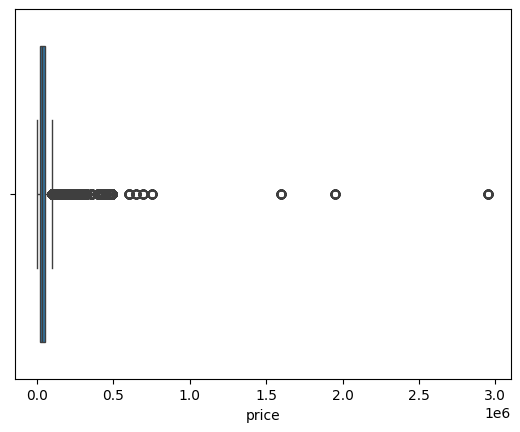

In [ ]:
sns.boxplot(x=df['price'])

<Axes: xlabel='milage'>

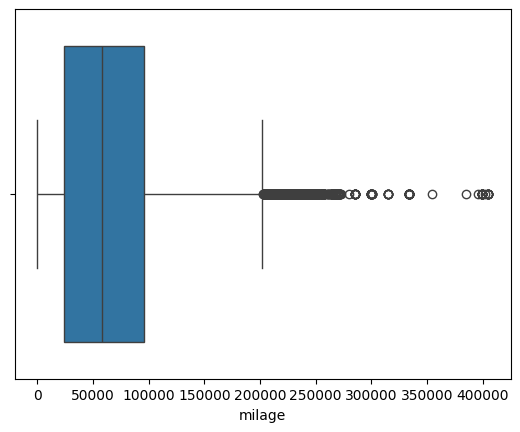

In [ ]:
sns.boxplot(x=df['milage'])

<Axes: xlabel='milage'>

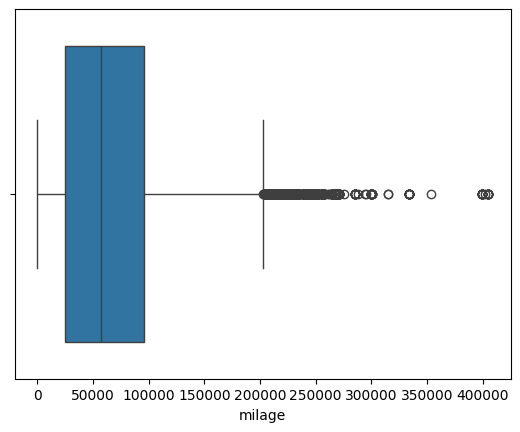

In [ ]:
sns.boxplot(x=test['milage'])

<Axes: xlabel='model_year'>

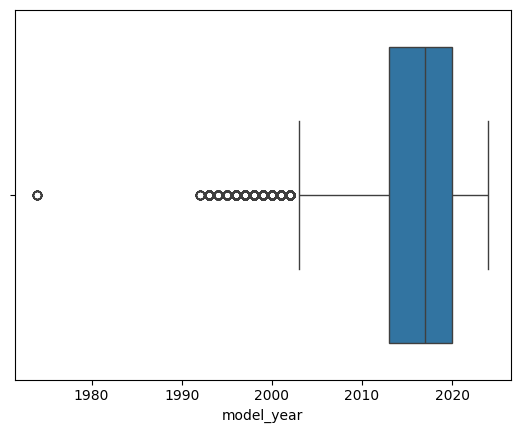

In [ ]:
sns.boxplot(x=df['model_year'])

<Axes: xlabel='model_year'>

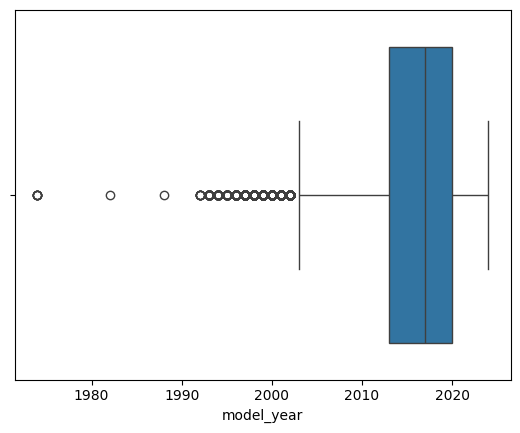

In [ ]:
sns.boxplot(x=test['model_year'])

In [ ]:
df['price'] = handle_outliers(df['price'], 2)
df['milage'] = handle_outliers(df['milage'], 2)
df['model_year'] = handle_outliers(df['model_year'], 2)

test['milage'] = handle_outliers(test['milage'], 2)
test['model_year'] = handle_outliers(test['model_year'], 2)

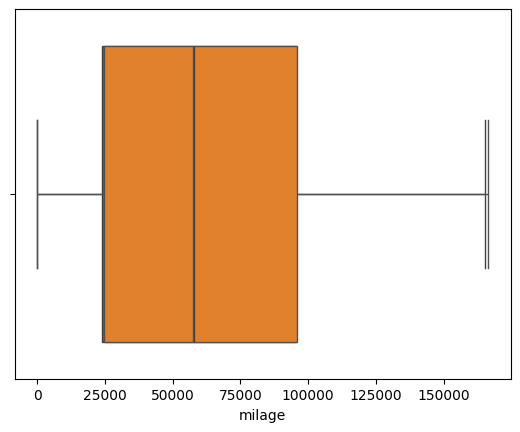

In [ ]:
sns.boxplot(x=df['milage']);
sns.boxplot(x=test['milage']);

<Axes: xlabel='price'>

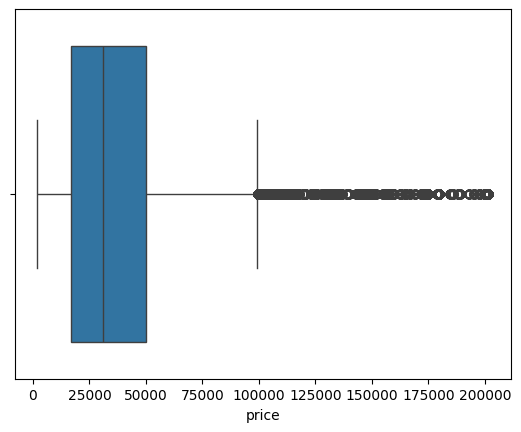

In [ ]:
sns.boxplot(x=df['price'])

<Axes: xlabel='model_year'>

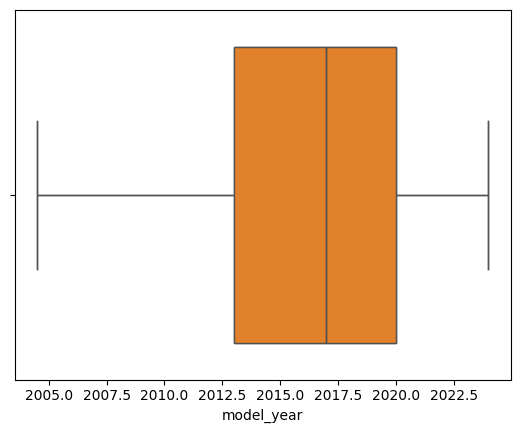

In [ ]:
sns.boxplot(x=df['model_year']);
sns.boxplot(x=df['model_year'])

In [ ]:
'''df['price'] = np.sqrt(df['price'] + 1)'''

"df['price'] = np.sqrt(df['price'] + 1)"

# Feature Engineering

Functions to extract features from original dataset

In [ ]:
# Categorical
def get_automatic(string):
    string = string.lower()
    if 'a/t' in string or 'automatic' in string or 'at' in string:
        return 1
    else:
        return 0

In [ ]:
# Categorical
def get_gears(string):
    match = re.search(r'^(\d+)-Speed', string, re.IGNORECASE)
    if match:
        gears = match.group(1)
        return int(gears)
    else:
        return None

In [ ]:
# Contiunuos
def get_hp(engine):
    match = re.search(r'([\d.]+)HP', engine, re.IGNORECASE)
    if match:
      return float(match.group(1))
    else:
      return None

In [ ]:
# Continuos
def get_L(engine):
    match = re.search(r'([\d.]+)L', engine, re.IGNORECASE)
    if match:
      return float(match.group(1))
    else:
      return None

In [ ]:
# Categorical
def get_cyl(engine):
    match = re.search(r'([\d.]+)?\s?(?:Cylinder|Cyl|Cylinders)', engine, re.IGNORECASE)
    if match:
      return int(match.group(1))
    else:
      return None

In [ ]:
# Categorical
def is_electric(engine):
    if 'electric' in engine.lower():
      return 1
    else:
      return 0

In [ ]:
# Continuos
def num_valves(engine):
    match = re.search(r'([\d+])V', engine)
    if match:
      return float(match.group(1))
    else:
      return None

In [ ]:
# Categorical
def is_accident(accident):
    if type(accident) == str:
        if 'accident' in accident.lower():
          return 1
        else:
          return 0
    else:
        return None

Functions to extract featurs

In [ ]:
# Create features and insert into dataframe

def create_features(df):
    ''' Returns dataframe with newly created features '''
    df['automatic'] = df['transmission'].apply(get_automatic)
    df['gears'] = df['transmission'].apply(get_gears)
    df['hp'] = df['engine'].apply(get_hp)
    df['L'] = df['engine'].apply(get_L)
    df['cylinders'] = df['engine'].apply(get_cyl)
    df['accident'] = df['accident'].apply(is_accident)
    df['electric'] = df['engine'].apply(is_electric)
    df['valves'] = df['engine'].apply(num_valves)
    return df

def create_interactions(df):
    ''' Returns dataframe with newly created interaction features'''
    df['hp/l'] = np.where(df['L'] != 0, df['hp'] / df['L'], None).astype('float')
    df['mil/l'] = np.where(df['L'] != 0, df['milage'] / df['L'], None).astype('float')
    df['mil/hp'] = np.where(df['hp'] != 0, df['milage'] / df['hp'], None).astype('float')
    df['l/cyl'] = np.where(df['cylinders'] != 0, df['L'] / df['cylinders'], None).astype('float')
    df['hp/gears'] = np.where(df['gears'] != 0, df['hp'] / df['gears'], None).astype('float')
    df['mil/gears'] = np.where(df['gears'] != 0, df['milage'] / df['gears'], None).astype('float')
    df['mil/cyl'] = np.where(df['cylinders'] != 0, df['milage'] / df['cylinders'], None).astype('float')

    df['hp*automatic'] = df['hp'] * df['automatic']
    df['cyl*gears'] = df['cylinders'] * df['gears']

    df['carAge'] = pd.Series(2024 - df['model_year']).astype('int')
    df['mil/year'] = np.where(df['carAge'] != 0, df['milage'] / df['carAge'], None).astype('float')
    df['hp*accident'] = pd.Series(df['hp'] * df['accident']).astype('float')
    df['accident*carAge'] = pd.Series(df['accident'] * df['carAge']).astype('float')
    df['acc*milage'] = pd.Series(df['accident'] * df['milage']).astype('float')

    df['mil*carAge'] = pd.Series(df['milage'] * df['carAge']).astype('float')
    df['hp*mil'] = pd.Series(df['hp'] * df['milage']).astype('float')
    return df

In [ ]:
df = create_features(df)
test = create_features(test)

In [ ]:
# We will treat some suitable variables as categorical
cleaner.update_vars(e_categoricals = ['L', 'cylinders', 'gears'])
test_cleaner.update_vars(e_categoricals = ['L', 'cylinders', 'gears'])

### Treat missing values of variables

In [ ]:
print(df.isnull().sum(), test.isnull().sum())

brand                0
model                0
model_year           0
milage               0
fuel_type            0
engine               0
transmission         0
ext_col              0
int_col              0
accident             0
clean_title          0
price                0
automatic            0
gears            84434
hp               33259
L                14214
cylinders        37855
electric             0
valves          165115
dtype: int64 brand                0
model                0
model_year           0
milage               0
fuel_type            0
engine               0
transmission         0
ext_col              0
int_col              0
accident             0
clean_title          0
automatic            0
gears            56172
hp               22181
L                 9407
cylinders        25150
electric             0
valves          110069
dtype: int64


In [ ]:
cleaner.clean_categoricals()
cleaner.clean_continuos()

test_cleaner.clean_categoricals()
test_cleaner.clean_continuos()

categorical_missing_vars: ['automatic', 'gears', 'electric', 'cylinders', 'L']
continuos_missing_vars: ['milage', 'price', 'hp', 'valves']
categorical_missing_vars: ['automatic', 'gears', 'electric', 'cylinders', 'L']
continuos_missing_vars: ['milage', 'hp', 'valves']


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,automatic,gears,hp,L,cylinders,electric,valves
0,Land,Rover LR2 Base,2015.0,98000.0,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,0,Yes,1.0,6.0,240.000000,2.0,4.0,0.0,4.579028
1,Land,Rover Defender SE,2020.0,9142.0,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,0,Yes,1.0,8.0,395.000000,3.0,6.0,1.0,4.579028
2,Ford,Expedition Limited,2022.0,28121.0,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,0,Yes,1.0,10.0,342.797283,3.5,6.0,0.0,4.000000
3,Audi,A6 2.0T Sport,2016.0,61258.0,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,0,Yes,1.0,6.0,342.797283,3.0,6.0,0.0,4.579028
4,Audi,A6 2.0T Premium Plus,2018.0,59000.0,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,0,Yes,1.0,6.0,252.000000,2.0,4.0,0.0,4.579028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125685,Mercedes-Benz,GL-Class GL 450 4MATIC,2014.0,83315.0,Gasoline,362.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Black,0,Yes,1.0,7.0,362.000000,3.0,6.0,0.0,4.579028
125686,Audi,Q7 55 Prestige,2019.0,29336.0,Gasoline,3.0 Liter Turbo,Automatic,White,Black,0,Yes,1.0,6.0,342.797283,3.0,6.0,0.0,4.579028
125687,Audi,A6 3.0T Premium Plus,2012.0,77634.0,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,0,Yes,1.0,6.0,333.000000,3.0,6.0,0.0,4.579028
125688,Audi,Q7 3.0T Premium,2012.0,112000.0,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,0,Yes,1.0,6.0,333.000000,3.0,6.0,0.0,4.579028


In [ ]:
print(df.isnull().sum(), test.isnull().sum())

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
automatic       0
gears           0
hp              0
L               0
cylinders       0
electric        0
valves          0
dtype: int64 brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
automatic       0
gears           0
hp              0
L               0
cylinders       0
electric        0
valves          0
dtype: int64


### Create Interaction features

In [ ]:
# Create interaction features
df = create_interactions(df)
test = create_interactions(test)

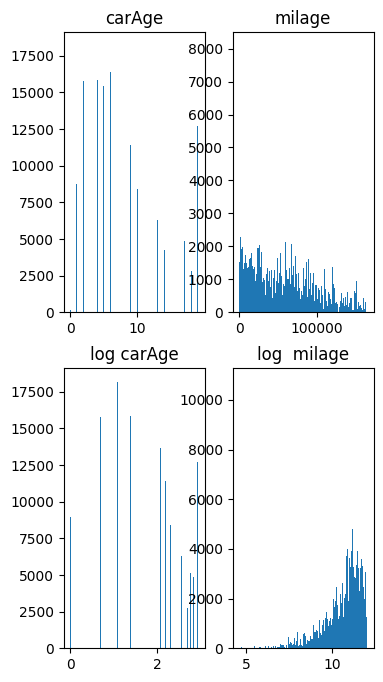

In [ ]:
# Some features with rightly skewed data can be log transformed
fig, axs = plt.subplots(2, 2, figsize=(4, 8))

# carAge distribution
axs[0, 0].hist(df['carAge'], bins=200)
axs[0, 0].set_title('carAge')

axs[0, 1].hist(df['milage'], bins=200)
axs[0, 1].set_title('milage')

# milage is right skewed. Log transformation could be used.
carAge = np.where(df['carAge'] != 0, df['carAge'], 1).astype('float')
milage = np.where(df['milage'] != 0, df['milage'], 1).astype('float')

log_carAge = np.log(carAge)
log_milage = np.log(milage)

axs[1, 0].hist(log_carAge, bins=200)
axs[1, 0].set_title('log carAge')

axs[1,1].hist(log_milage, bins=200,)
axs[1,1].set_title('log  milage')
plt.show()

In [ ]:
# Add binning to milage and categorize ordinally
milage = df['milage']

# Get range of values
print(np.min(milage), np.max(milage))

bins = [99.0, 300.0, 700.0, 1000.0, 3000.0, 7000., 10000.0, 20000., 35000., 50000.0, 75000, 100000.0, 125000.0, 150000., 175000.]

binned_milage = pd.cut(milage, bins, right=False)

# mils_bins_category is dict of structure {interval: int} where int is increasing from 0 to 5: there are 6 Intervals
mils_bins_category = {}
for i in range(0, len(bins) - 1, 1):
    mils_bins_category[pd.Interval(bins[i], bins[i+1], closed='left')] = i

100.0 165301.61132529768


In [ ]:
# Assign classes to brands according to their mean prices
# Classes are of type int, ordinally categorized

# Get range of values
print(np.min(df['price']), np.max(df['price']))

bins = [1000.0, 5000.0, 10000.0, 25000.0, 50000.0, 75000., 100000.0, 125000., 150000.0, 175000., 200000.0, 225000., 250000.0, 275000.0, 300000.0]

binned_prices = pd.cut(df['price'], bins, right=False) # 9 Intervals

# Create bins category mapping
bins_category = {pd.Interval(bins[i], bins[i+1], closed='left'): i for i in range(len(bins) - 1)}

# Create dict {'brand_name' : mean_price}
brand_avg_price = df.groupby('brand')['price'].mean().to_dict()


def get_class(mprice):
    ''' Returns category of mean price
    Args:
    mprice(float) : Mean price
    Returns:
    category(int): Category of interval in which mrice lies
    '''

    for interval, category in bins_category.items():
        if mprice in interval:
          return category

2000.0 201517.06068646687


In [ ]:
def additional_features(df):
    df['AverageMilage'] = df.groupby("brand")['milage'].transform('mean')
    df['BrandFreq'] = df.groupby('brand')['brand'].transform('count')/df['brand'].count()

    brand_count = df.groupby('brand')['brand'].count().to_dict() #{'brand_name' : mean_price}
    df['brand_count'] = df['brand'].map(brand_count)

    brand_avg_mil = df.groupby('brand')['milage'].mean().to_dict() #{'brand_name' : mean_price}
    df['brand_avg_mil'] = df['brand'].map(brand_avg_mil)

    df['binned_milage'] = binned_milage.map(lambda x: mils_bins_category[x])

    brand_class = {brand: get_class(price) for brand, price in brand_avg_price.items()}
    df['brand_class'] = df['brand'].map(lambda x: brand_class[x])

    df['log_milage'] = np.log(df['milage'])

    df['logL'] = np.log(df['L'])

    df['logAge'] = np.log1p(df['carAge'])


    return df

In [ ]:
df = additional_features(df)
test = additional_features(test)

In [ ]:
cleaner.clean_continuos()
test_cleaner.clean_continuos()

continuos_missing_vars: ['hp/l', 'mil/l', 'mil/hp', 'l/cyl', 'hp/gears', 'mil/gears', 'mil/cyl', 'hp*automatic', 'cyl*gears', 'mil/year', 'hp*accident', 'accident*carAge', 'acc*milage', 'mil*carAge', 'hp*mil', 'AverageMilage', 'BrandFreq', 'brand_avg_mil', 'log_milage', 'logL', 'logAge']
continuos_missing_vars: ['hp/l', 'mil/l', 'mil/hp', 'l/cyl', 'hp/gears', 'mil/gears', 'mil/cyl', 'hp*automatic', 'cyl*gears', 'mil/year', 'hp*accident', 'accident*carAge', 'acc*milage', 'mil*carAge', 'hp*mil', 'AverageMilage', 'BrandFreq', 'brand_avg_mil', 'log_milage', 'logL', 'logAge']


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,hp*mil,AverageMilage,BrandFreq,brand_count,brand_avg_mil,binned_milage,brand_class,log_milage,logL,logAge
0,Land,Rover LR2 Base,2015.0,98000.0,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,0,...,2.352000e+07,54164.559104,0.050505,6348,54164.559104,13,3,11.492723,0.693147,2.302585
1,Land,Rover Defender SE,2020.0,9142.0,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,0,...,3.611090e+06,54164.559104,0.050505,6348,54164.559104,12,3,9.120634,1.098612,1.609438
2,Ford,Expedition Limited,2022.0,28121.0,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,0,...,9.639802e+06,70133.642873,0.121450,15265,70133.642873,12,3,10.244272,1.252763,1.098612
3,Audi,A6 2.0T Sport,2016.0,61258.0,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,0,...,2.099908e+07,58676.868494,0.057992,7289,58676.868494,6,3,11.022850,1.098612,2.197225
4,Audi,A6 2.0T Premium Plus,2018.0,59000.0,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,0,...,1.486800e+07,58676.868494,0.057992,7289,58676.868494,5,3,10.985293,0.693147,1.945910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125685,Mercedes-Benz,GL-Class GL 450 4MATIC,2014.0,83315.0,Gasoline,362.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Black,0,...,3.016003e+07,54557.687165,0.102435,12875,54557.687165,7,3,11.330384,1.098612,2.397895
125686,Audi,Q7 55 Prestige,2019.0,29336.0,Gasoline,3.0 Liter Turbo,Automatic,White,Black,0,...,1.005630e+07,58676.868494,0.057992,7289,58676.868494,9,3,10.286571,1.098612,1.791759
125687,Audi,A6 3.0T Premium Plus,2012.0,77634.0,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,0,...,2.585212e+07,58676.868494,0.057992,7289,58676.868494,4,3,11.259761,1.098612,2.564949
125688,Audi,Q7 3.0T Premium,2012.0,112000.0,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,0,...,3.729600e+07,58676.868494,0.057992,7289,58676.868494,5,3,11.626254,1.098612,2.564949


In [ ]:
# Label categorical features
for colname in cleaner.categoricals:
    df[colname], _ = df[colname].factorize()

for colname in test_cleaner.categoricals:
    test[colname], _ = test[colname].factorize()

In [ ]:
X = df.copy()
y = X.pop('price')

In [ ]:
X.shape

(188533, 43)

In [ ]:
test.shape

(125690, 43)

#### PCA

In [ ]:
# Standardize the data (important for PCA)
X_pca = X.copy()
test_pca = test.copy()

scaler_pca = StandardScaler()

X_pca[X_pca.select_dtypes(include='float').columns] = scaler_pca.fit_transform(X_pca.select_dtypes(include='float'))
test_pca[X_pca.select_dtypes(include='float').columns] = scaler_pca.fit_transform(test_pca.select_dtypes(include='float'))
print(X_pca.select_dtypes(include='float').columns)

# Apply PCA
pca = PCA(n_components=2)  # Specify the number of components
X_pca_components = pca.fit_transform(X_pca)
test_pca_components = pca.fit_transform(test_pca)

# Explained Variance
explained_variance = np.sum(pca.explained_variance_ratio_)

print("Explained Variance Ratio:", explained_variance)

# Convert to DataFrame for better readability
pca_df = pd.DataFrame(data=X_pca_components, columns=['PC1', 'PC2'])
X = pd.concat([X, pca_df], axis=1)

pca_df = pd.DataFrame(data=test_pca_components, columns=['PC1', 'PC2'])
test = pd.concat([test, pca_df], axis=1)

Index(['milage', 'hp', 'valves', 'hp/l', 'mil/l', 'mil/hp', 'l/cyl',
       'hp/gears', 'mil/gears', 'mil/cyl', 'hp*automatic', 'cyl*gears',
       'mil/year', 'hp*accident', 'accident*carAge', 'acc*milage',
       'mil*carAge', 'hp*mil', 'AverageMilage', 'BrandFreq', 'brand_avg_mil',
       'log_milage', 'logL', 'logAge'],
      dtype='object')
Explained Variance Ratio: 0.9919154790982543


In [ ]:
cleaner.categoricals.extend(['PC1', 'PC2'])
test_cleaner.categoricals.extend(['PC1', 'PC2'])

In [ ]:
# See loadings

# Get the principal components (PCs)
components = pca.components_
print(components.shape)

# Create a DataFrame for easy visualization
components_df = pd.DataFrame(components, columns=X_pca.columns, index=['PC1', 'PC2'])

# Display the loadings (contributions of each feature to each component)
components_df

(2, 43)


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,hp*mil,AverageMilage,BrandFreq,brand_count,brand_avg_mil,binned_milage,brand_class,log_milage,logL,logAge
PC1,0.006061,0.972764,0.000282,0.000035,0.000117,0.231487,0.000563,0.007673,0.001991,0.000029,...,-0.000100,0.000074,-0.000579,0.006061,0.000074,0.000010,0.000219,-0.000012,-0.000287,0.000034
PC2,0.003505,-0.231482,0.002367,0.000418,0.000378,0.972737,0.001848,-0.008460,-0.001269,0.000069,...,0.000312,0.000155,-0.000199,0.003505,0.000155,-0.000038,0.000538,0.000215,0.000178,0.000643


In [ ]:
me_en = np.where(X['engine'] != 0, X['model'] / X['engine'], 0)

In [ ]:
me_bf = X['BrandFreq'] * X['engine']
me_bf_mi = mutual_info_regression(pd.DataFrame(me_bf), y)

In [ ]:
me_bf_mi

array([0.42489782])

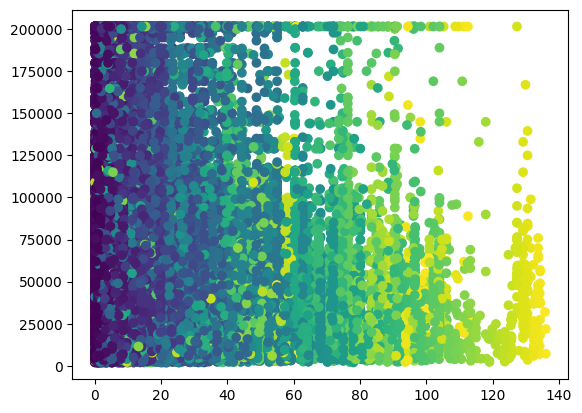

In [ ]:
plt.scatter(me_bf, y, c=X['engine'])

In [ ]:
X['me_bfr'] = me_bf
test['me_bfr'] = test['BrandFreq'] * test['engine']

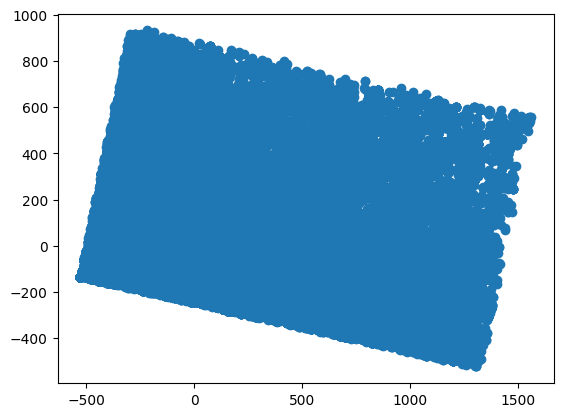

In [ ]:
plt.scatter(X['PC1'], X['PC2'])

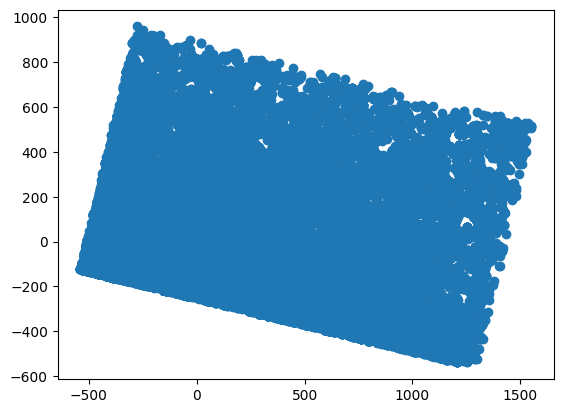

In [ ]:
plt.scatter(test['PC1'], test['PC2'])

#### K-means Clustering

In [ ]:
# Add cluster feature
c_scaler = StandardScaler()

kmeans = KMeans(n_clusters=3, n_init=10)

XC = [col for col in X.columns if col not in cleaner.categoricals]
XC = X[XC]
XC = c_scaler.fit_transform(XC)
X['Cluster'] = kmeans.fit_predict(XC)
X['Cluster'] = X['Cluster'].astype('int')

test_conts = [col for col in test.columns if col not in test_cleaner.categoricals]
test_conts = test[test_conts]
test_conts = c_scaler.transform(test_conts)
test['Cluster'] = kmeans.fit_predict(test_conts)
test['Cluster'] = test['Cluster'].astype('int')

In [ ]:
cleaner.categoricals.extend(['Cluster'])
test_cleaner.categoricals.extend(['Cluster'])

#### Output of a trained Ridge model as a feature

In [ ]:
r_model = Ridge(alpha=1)
r_model.fit(X, y)

print(f'train error: {np.sqrt(mean_squared_error(r_model.predict(X), y))}')

X['r_predict'] = r_model.predict(X)
test['r_predict'] = r_model.predict(test)

train error: 27194.020795081204


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.23482e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [ ]:
'''cols = ['model', 'fuel_type', 'brand', 'int_col', 'ext_col', 'transmission', 'brand_class', 'Cluster',]

# One-hot encoding
encoded_data = pd.get_dummies(X[cols].astype('str'))
X = pd.concat([X, encoded_data], axis=1)

# Remove original encoded features
X = X.drop(cols, axis=1)

# Update categoricals list in cleaner
cleaner.categoricals = [col for col in cleaner.categoricals if col not in cols]
cleaner.categoricals.extend(encoded_data.columns.tolist())
len(cleaner.categoricals)'''

"cols = ['model', 'fuel_type', 'brand', 'int_col', 'ext_col', 'transmission', 'brand_class', 'Cluster',]\n\n# One-hot encoding\nencoded_data = pd.get_dummies(X[cols].astype('str'))\nX = pd.concat([X, encoded_data], axis=1)\n\n# Remove original encoded features\nX = X.drop(cols, axis=1)\n\n# Update categoricals list in cleaner\ncleaner.categoricals = [col for col in cleaner.categoricals if col not in cols]\ncleaner.categoricals.extend(encoded_data.columns.tolist())\nlen(cleaner.categoricals)"

In [ ]:
print(df.isnull().sum(), test.isnull().sum())

brand              0
model              0
model_year         0
milage             0
fuel_type          0
engine             0
transmission       0
ext_col            0
int_col            0
accident           0
clean_title        0
price              0
automatic          0
gears              0
hp                 0
L                  0
cylinders          0
electric           0
valves             0
hp/l               0
mil/l              0
mil/hp             0
l/cyl              0
hp/gears           0
mil/gears          0
mil/cyl            0
hp*automatic       0
cyl*gears          0
carAge             0
mil/year           0
hp*accident        0
accident*carAge    0
acc*milage         0
mil*carAge         0
hp*mil             0
AverageMilage      0
BrandFreq          0
brand_count        0
brand_avg_mil      0
binned_milage      0
brand_class        0
log_milage         0
logL               0
logAge             0
dtype: int64 brand              0
model              0
model_year         0


In [ ]:
# Scale train continuos features
continuos_features_to_scale = [col for col in X.columns if col not in cleaner.categoricals]
print(f'Features to be scaled: {continuos_features_to_scale}')

scalerTrain = StandardScaler()
X[continuos_features_to_scale] = scalerTrain.fit_transform(X[continuos_features_to_scale])

Features to be scaled: ['milage', 'hp', 'valves', 'hp/l', 'mil/l', 'mil/hp', 'l/cyl', 'hp/gears', 'mil/gears', 'mil/cyl', 'hp*automatic', 'cyl*gears', 'mil/year', 'hp*accident', 'accident*carAge', 'acc*milage', 'mil*carAge', 'hp*mil', 'AverageMilage', 'BrandFreq', 'brand_avg_mil', 'log_milage', 'logL', 'logAge', 'me_bfr', 'r_predict']


In [ ]:
# Scale test continuos features
continuos_features_to_scale = [col for col in test.columns if col not in test_cleaner.categoricals]
print(f'Features to be scaled: {continuos_features_to_scale}')

test[continuos_features_to_scale] = scalerTrain.transform(test[continuos_features_to_scale])

Features to be scaled: ['milage', 'hp', 'valves', 'hp/l', 'mil/l', 'mil/hp', 'l/cyl', 'hp/gears', 'mil/gears', 'mil/cyl', 'hp*automatic', 'cyl*gears', 'mil/year', 'hp*accident', 'accident*carAge', 'acc*milage', 'mil*carAge', 'hp*mil', 'AverageMilage', 'BrandFreq', 'brand_avg_mil', 'log_milage', 'logL', 'logAge', 'me_bfr', 'r_predict']


In [ ]:
selected_features = ['me_bfr', 'milage', 'log_milage', 'engine', 'mil*carAge', 'mil/cyl', 'mil/gears', 'hp/l', 'mil/hp', 'carAge', 'model_year', 'hp', 'logAge', 'PC1', 'hp/gears', 'r_predict', 'brand', 'model_year', 'milage', 'engine', 'transmission', 'ext_col', 'hp', 'valves', 'hp/l', 'mil/l', 'mil/hp', 'mil/gears', 'mil*carAge', 'AverageMilage', 'BrandFreq', 'brand_class', 'logAge', 'PC1', 'PC2', 'r_predict']

In [ ]:
X = X[selected_features]

In [ ]:
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.1, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, random_state=123)
print(X_train.shape, X_test.shape)

(169679, 36) (9427, 36)


### TensorFlow Neural Network

In [ ]:
# Define a custom RMSE metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, kernel_regularizer=tf.keras.regularizers.L2(2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1),
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=[rmse])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5)

Epoch 1/5
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 2183784192.0000 - rmse: 45340.7617 - val_loss: 1153764096.0000 - val_rmse: 32393.8008
Epoch 2/5
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 1564284544.0000 - rmse: 38264.1484 - val_loss: 1005753984.0000 - val_rmse: 30053.8750
Epoch 3/5
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 1478711296.0000 - rmse: 37226.7109 - val_loss: 973924224.0000 - val_rmse: 29556.0312
Epoch 4/5
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 1471521152.0000 - rmse: 37088.7344 - val_loss: 959811904.0000 - val_rmse: 29342.0547
Epoch 5/5
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 1472539520.0000 - rmse: 37093.0156 - val_loss: 974661824.0000 - val_rmse: 29592.3125


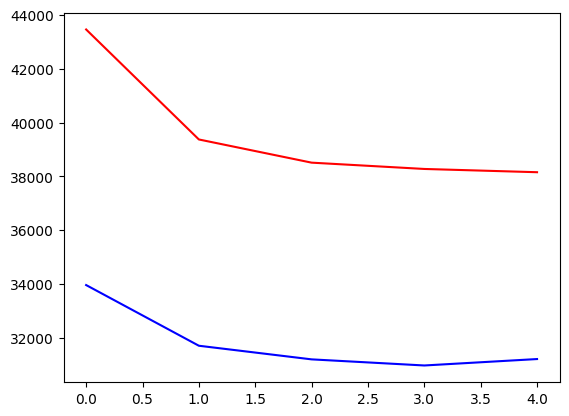

In [ ]:
t_loss = np.sqrt(history.history['loss'])
v_loss = np.sqrt(history.history['val_loss'])
plt.plot(t_loss, c='r')
plt.plot(v_loss, c='b')

In [ ]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test RMSE Loss: {np.sqrt(test_loss)}')

295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1031210176.0000 - rmse: 30297.6680
Test RMSE Loss: [30947.6150939    171.28100769]


### XGB Regressor Model

In [ ]:
x_train = X_train.values
y_train = y_train.values
x_cv = X_val.values
y_cv = y_val.values
x_test = X_test.values
y_test = y_test.values

In [ ]:
xgb_model = XGBRegressor(learning_rate= 0.1,
                        max_depth = 4,
                        n_estimators = 900,
                        enable_categorical=True,
                        subsample= 0.7,
                        reg_lambda=0.8,
                     )

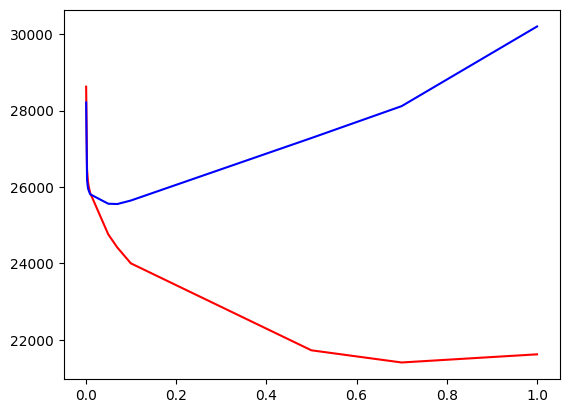

In [ ]:
rates = [0.001, 0.003, 0.005, 0.007, 0.01, 0.05, 0.07, 0.1, 0.5, 0.7, 1.0]
cv = []
tr = []

for rate in rates:
    xgb_model = XGBRegressor(learning_rate= rate,
                        max_depth = 4,
                        n_estimators = 900,
                        enable_categorical=True,
                        subsample= 0.7,
                        reg_lambda=0.8,
                     )
    xgb_model.fit(x_train, y_train)
    ypred = xgb_model.predict(x_train)
    xgb_train_mse = mean_squared_error(y_train, ypred)
    tr.append(np.sqrt(xgb_train_mse))

    ypred = xgb_model.predict(x_cv)
    xgb_cv_mse = mean_squared_error(y_cv, ypred)
    cv.append(np.sqrt(xgb_cv_mse))
plt.plot(rates, tr, c='r')
plt.plot(rates, cv, c='b')


In [ ]:
rates[np.argmin(cv)]

0.05

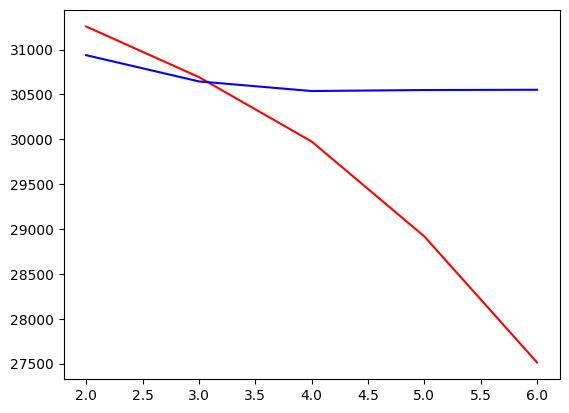

In [ ]:
rates = [2, 3, 4, 5, 6]
cv = []
tr = []

for rate in rates:
    xgb_model = XGBRegressor(learning_rate= 0.05,
                        max_depth = rate,
                        n_estimators = 900,
                        enable_categorical=True,
                        subsample= 0.7,
                        reg_lambda=0.8,
                     )
    xgb_model.fit(x_train, y_train)
    ypred = xgb_model.predict(x_train)
    xgb_train_mse = mean_squared_error(y_train, ypred)
    tr.append(np.sqrt(xgb_train_mse))

    ypred = xgb_model.predict(x_cv)
    xgb_cv_mse = mean_squared_error(y_cv, ypred)
    cv.append(np.sqrt(xgb_cv_mse))
plt.plot(rates, tr, c='r')
plt.plot(rates, cv, c='b')


In [ ]:
rates[np.argmin(cv)]

4

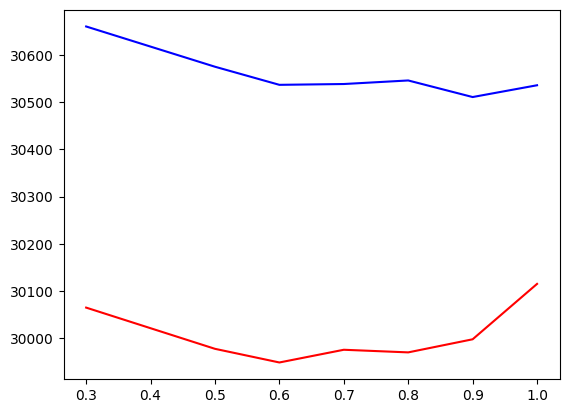

In [ ]:
rates = [0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
cv = []
tr = []

for rate in rates:
    xgb_model = XGBRegressor(learning_rate= 0.05,
                        max_depth = 4,
                        n_estimators = 500,
                        enable_categorical=True,
                        subsample= rate,
                        reg_lambda=0.8,
                     )
    xgb_model.fit(x_train, y_train)
    ypred = xgb_model.predict(x_train)
    xgb_train_mse = mean_squared_error(y_train, ypred)
    tr.append(np.sqrt(xgb_train_mse))

    ypred = xgb_model.predict(x_cv)
    xgb_cv_mse = mean_squared_error(y_cv, ypred)
    cv.append(np.sqrt(xgb_cv_mse))
plt.plot(rates, tr, c='r')
plt.plot(rates, cv, c='b')


In [ ]:
rates[np.argmin(cv)]

0.9

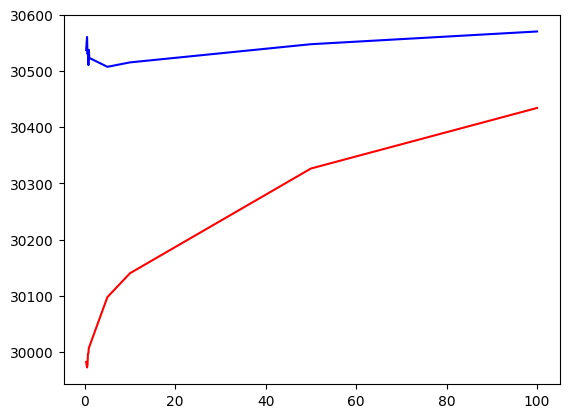

In [ ]:
rates = [0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 5.0, 10., 50., 100.]
cv = []
tr = []

for rate in rates:
    xgb_model = XGBRegressor(learning_rate= 0.05,
                        max_depth = 4,
                        n_estimators = 500,
                        enable_categorical=True,
                        subsample= 0.9,
                        reg_lambda=rate,
                     )
    xgb_model.fit(x_train, y_train)
    ypred = xgb_model.predict(x_train)
    xgb_train_mse = mean_squared_error(y_train, ypred)
    tr.append(np.sqrt(xgb_train_mse))

    ypred = xgb_model.predict(x_cv)
    xgb_cv_mse = mean_squared_error(y_cv, ypred)
    cv.append(np.sqrt(xgb_cv_mse))
plt.plot(rates, tr, c='r')
plt.plot(rates, cv, c='b')


In [ ]:
rates[np.argmin(cv)]

5.0

In [ ]:
xgb_model = XGBRegressor(learning_rate= 0.05,
                        max_depth = 4,
                        n_estimators = 500,
                        enable_categorical=True,
                        subsample= 0.9,
                        reg_lambda=5.0,
                     )

In [ ]:
# Train model
xgb_model.fit(x_train, y_train)

# Calculate RMSE
ypred = xgb_model.predict(x_train)
xgb_train_mse = mean_squared_error(y_train, ypred)

np.sqrt(xgb_train_mse)

25326.619217770687

In [ ]:
ypred = xgb_model.predict(x_train)
xgb_train_mse = mean_squared_error(y_train, ypred)
xgb_train_mse = np.sqrt(xgb_train_mse)

ypred = xgb_model.predict(x_cv)
xgb_cv_mse = mean_squared_error(y_cv, ypred)
xgb_cv_mse = np.sqrt(xgb_cv_mse)


print(f'train MSE: {xgb_train_mse}\nValidation MSE: {xgb_cv_mse}')
print(f'Difference: {abs(xgb_train_mse - xgb_cv_mse):.4f}')


train MSE: 25326.619217770687
Validation MSE: 25651.7462809522
Difference: 325.1271


In [ ]:
y_pred = xgb_model.predict(x_test)
test_error = mean_squared_error(y_pred, y_test)
np.sqrt(test_error)

25889.89848918659

In [ ]:
'''from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_distributions = {
    'n_estimators': np.arange(100, 1000, 100),         # Number of trees
    'max_depth': np.arange(3, 10),                     # Tree depth
    'learning_rate': np.linspace(0.01, 0.3, 10),       # Learning rate (eta)
    'subsample': np.linspace(0.5, 1.0, 5),             # Subsample ratio
    'colsample_bytree': np.linspace(0.5, 1.0, 5),      # Column subsampling
    'gamma': np.linspace(0, 5, 10),                    # Minimum loss reduction
    'alpha': np.linspace(0, 1, 10),                    # L1 regularization
    'lambda': np.linspace(0, 1, 10)                    # L2 regularization
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,                 # Number of random combinations to try
    scoring='neg_mean_squared_error',  # Evaluation metric
    cv=3,                      # 3-fold cross-validation
    verbose=1,                 # Print progress
    random_state=42,           # Reproducibility
    n_jobs=-1,
)

# Fit RandomizedSearchCV
random_search.fit(x_train, y_train)

# Best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)
'''

'from sklearn.model_selection import RandomizedSearchCV\n\n# Define the parameter grid\nparam_distributions = {\n    \'n_estimators\': np.arange(100, 1000, 100),         # Number of trees\n    \'max_depth\': np.arange(3, 10),                     # Tree depth\n    \'learning_rate\': np.linspace(0.01, 0.3, 10),       # Learning rate (eta)\n    \'subsample\': np.linspace(0.5, 1.0, 5),             # Subsample ratio\n    \'colsample_bytree\': np.linspace(0.5, 1.0, 5),      # Column subsampling\n    \'gamma\': np.linspace(0, 5, 10),                    # Minimum loss reduction\n    \'alpha\': np.linspace(0, 1, 10),                    # L1 regularization\n    \'lambda\': np.linspace(0, 1, 10)                    # L2 regularization\n}\n\n# Initialize RandomizedSearchCV\nrandom_search = RandomizedSearchCV(\n    estimator=xgb_model,\n    param_distributions=param_distributions,\n    n_iter=50,                 # Number of random combinations to try\n    scoring=\'neg_mean_squared_error\',  # Evalu

In [ ]:
'''# Obtained by running RandomSearchCV for 23 mins with t4 gpu
best_parameters= {'subsample': 0.875,
                  'n_estimators': 900,
                  'max_depth': 7,
                  'learning_rate': 0.042222222222222223,
                  'lambda': 100.0,
                  'gamma': 1.6666666666666667,
                  'colsample_bytree': 0.3,
                  'alpha': 0.4444444444444444,
                  'subsample': 0.3,
                  'alpha':100,
                  'min_child_weight':10,
                     }
s_model = XGBRegressor(**best_parameters)'''

(array([4.3870e+04, 5.1657e+04, 4.0557e+04, 1.9971e+04, 9.2690e+03,
        2.7890e+03, 9.6400e+02, 4.6000e+02, 1.2400e+02, 1.8000e+01]),
 array([   472.20080566,  20304.10546875,  40136.01171875,  59967.9140625 ,
         79799.8203125 ,  99631.7265625 , 119463.6328125 , 139295.53125   ,
        159127.4375    , 178959.34375   , 198791.25      ]),
 <BarContainer object of 10 artists>)

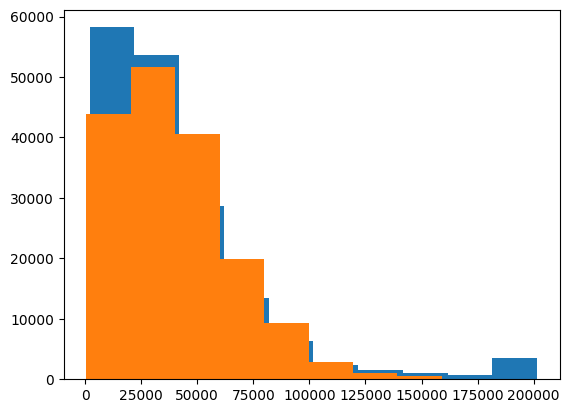

In [ ]:
train_pred = xgb_model.predict(x_train)
plt.hist(y_train)
plt.hist(train_pred)

In [ ]:
train_pred = xgb_model.predict(x_train)

### Submission

In [ ]:
pred = xgb_model.predict(test[selected_features].values).flatten()

In [ ]:
submision = pd.DataFrame({'id': id, 'price': pred})

In [ ]:
submision.to_csv('submission.csv', index=False)

(array([3.6764e+04, 3.5013e+04, 2.8636e+04, 1.3722e+04, 6.6490e+03,
        3.2900e+03, 1.0290e+03, 4.2100e+02, 1.3800e+02, 2.8000e+01]),
 array([  2753.89746094,  21125.06640625,  39496.234375  ,  57867.40234375,
         76238.5703125 ,  94609.734375  , 112980.90625   , 131352.078125  ,
        149723.234375  , 168094.40625   , 186465.578125  ]),
 <BarContainer object of 10 artists>)

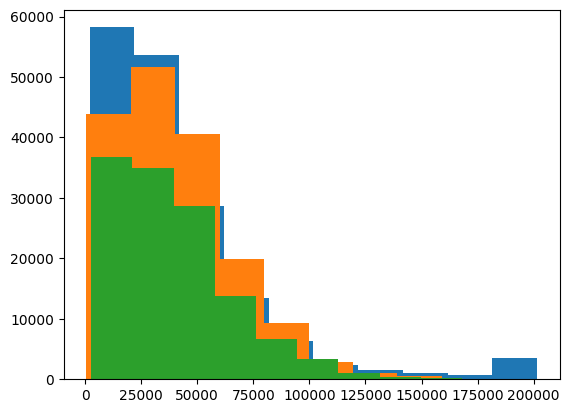

In [ ]:
plt.hist(y_train)
plt.hist(train_pred)
plt.hist(pred)

### Thank you.